In [30]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

from skimage.color import label2rgb
from skimage import measure
from imageio import imread, imsave
from PIL import Image

from skimage.morphology import binary_opening, binary_closing
from scipy.ndimage.morphology import binary_fill_holes
from skimage.feature import canny

In [306]:
# BAD Answer - 59, 47, 58, 60, 61
# OK Answer - 37, 39, 40, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 61

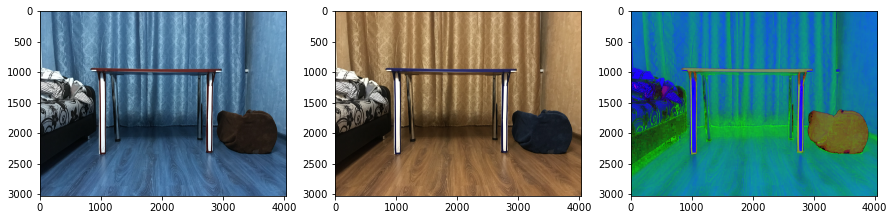

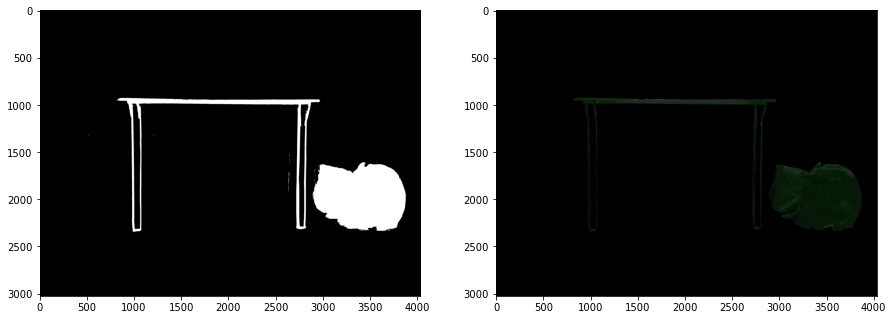

In [453]:
# Загрузим фотографию и удем искать наши объекты с помощью методов определения границ по цвету
# Так как стул обернут в синюю ткань, а внешний вид стола был подвергнут маодернизации
# ввиду проблем с нахождением границ такими методами как Canny или Хаффа
# Мы будем искать на изображении оттенки синего в диапазоне этого цвета

image = cv2.imread('./dataset/IMG_9844.jpg')
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

image_2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

hsv_image = cv2.cvtColor(image_2, cv2.COLOR_RGB2HSV)
light_blue = (82, 25, 0)                                            # Нижняя граница синего цвета в палитре HSV
dark_blue = (161, 255, 255)                                         # Верхняя граница синего цвета в палитре HSV
mask_blue = cv2.inRange(hsv_image, light_blue, dark_blue)
result_blue = cv2.bitwise_and(image, image_2, mask=mask_blue)

ax[0].imshow(image)
ax[1].imshow(image_2)
ax[2].imshow(hsv_image)
fig1, ax1 = plt.subplots(1, 2, figsize=(15, 6))
ax1[0].imshow(mask_blue, cmap="gray")
ax1[1].imshow(result_blue)
isWritten = cv2.imwrite('./dataset/work_image.jpg', mask_blue)

<ipython-input-454-b7fae6f6b4ec>:8: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  img3 = label2rgb(mask_img, image=mask_blue)


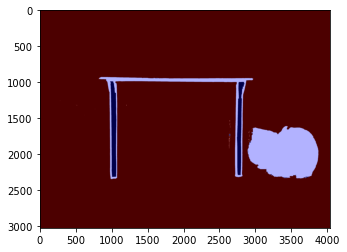

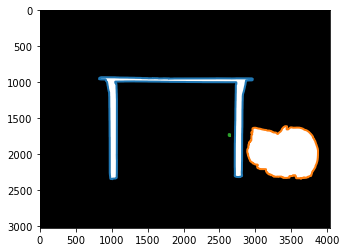

In [454]:
# Полученное изображение контуров белого цвета на черном фоне пропускаем через Canny и находим границы наших объектов

binary_img = binary_closing(canny(mask_blue, sigma=0.8), selem=np.ones((10, 10))) #1;6
img_segment = binary_fill_holes(binary_img)
mask_img = binary_opening(img_segment, selem=np.ones((16, 16)))#35;25


img3 = label2rgb(mask_img, image=mask_blue)

plt.imshow(img3)

# Находим контуры
contours_img = measure.find_contours(mask_img, 0.8)


# Отображаем для наглядности
fig, ax = plt.subplots()
ax.imshow(mask_img, cmap=plt.cm.gray)

for contour in contours_img:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.show()

In [470]:
# Метод для нахождения левой, правой, верхней и нижней точки, а также для нахождения ширины и высоты объектов
def find_square(contour):
    max_x = contour[0]
    max_y = contour[0]
    min_x = contour[0]
    min_y= contour[0]
    for i in range(len(contour)):
        pair = contour[i]
        if max_x[1] < pair[1]:
            max_x = pair
        if min_x[1] > pair[1]:
            min_x = pair
        if min_y[0] < pair[0]:
            min_y = pair
        if max_y[0] > pair[0]:
            max_y = pair
    
    
    if(max_y[1] < min_x[1]):
        min_x[1] = max_y[1]
        
    
    width = max_x[1] - min_x[1] 
    height = min_y[0] - max_y[0]
    
    return round(width * height), max_x, min_x, max_y, min_y, width, height

In [471]:
# Так как стул обернут в ткань, он заведомо имеет большую площадь нежели стол, поэтому будем считать,
# что площадь стола всегда больше и определим контур этого объекта как первый и найдем все необходимые нам составляющие
max_square = 0
for i in range(len(contours_img)):
    t,x1,x2,y1,y2, width, height = find_square(contours_img[i])
    if(t > max_square):
        ind = i
        max_square = t
        x_max = x1
        x_min = x2 
        y_max = y1 
        y_min = y2
        width_1 = width
        height_1 = height
         
print(max_square)
print(ind)
print(x_max, x_min, y_max, y_min, width_1, height_1)

3022445
0
[ 950.  2961.2] [957.  825.8] [928.8 853. ] [2344.2 1007. ] 2135.3999999999996 1415.3999999999999


In [472]:
# Находим все необходимое для стола
max_square2 = 0
for i in range(len(contours_img)):
    t,x1,x2,y1,y2, width, height = find_square(contours_img[i])
    if((t > max_square2) and (i != ind)):
        ind2 = i
        max_square2 = t
        x_max2 = x1
        x_min2 = x2 
        y_max2 = y1 
        y_min2 = y2
        width_2 = width
        height_2 = height
        
print(max_square2)
print(ind2)
print(x_max2, x_min2, y_max2, y_min2, width_2, height_2)

714809
1
[1951.  3871.2] [1971.  2885.8] [1609.8 3416. ] [2335.2 3632. ] 985.3999999999996 725.3999999999999


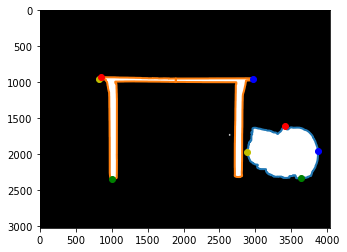

In [473]:
# Изобразим наши объекты и их крайние точки
fig, ax = plt.subplots()
ax.imshow(mask_img, cmap=plt.cm.gray)
if(max_square > max_square2):
    contour_1 = contours_img[ind2]
    contour_2 = contours_img[ind]
    cont = contour_2
    t = x_max
    x_max = x_max2
    x_max2 = t
    t = y_max
    y_max = y_max2
    y_max2 = t
    t = x_min
    x_min = x_min2
    x_min2 = t
    t = y_min
    y_min = y_min2
    y_min2 = t
    
    t = width_1
    width_1 = width_2
    width_2 = t
    
    t = height_1
    height_1 = height_2
    height_2 = t
else:        
    contour_1 = contours_img[ind]
    contour_2 = contours_img[ind2]
    cont = contour_1
    
ax.plot(contour_1[:, 1], contour_1[:, 0], linewidth=2)

ax.plot(contour_2[:, 1], contour_2[:, 0], linewidth=2)

ax.plot(x_max[1], x_max[0], 'bo') # --> самая правая
ax.plot(x_min[1], x_min[0], 'yo') # --> самая левая
ax.plot(y_max[1], y_max[0], 'ro') # --> самая верхняя
ax.plot(y_min[1], y_min[0], 'go') # --> самая нижнаяя

ax.plot(x_max2[1], x_max2[0], 'bo') # --> самая правая
ax.plot(x_min2[1], x_min2[0], 'yo') # --> самая левая
ax.plot(y_max2[1], y_max2[0], 'ro') # --> самая верхняя
ax.plot(y_min2[1], y_min2[0], 'go') # --> самая нижнаяя

plt.show()

In [474]:
# Проверяем не находится ли стул над столом и если так, то выдаем ошибку

if(y_min[0] < y_max2[0]):
    print("ERROR: table is stay under the cheir")

In [475]:
# Для того, чтобы далее определить внутренние точки для левой и правой ножек стола
# найдем среднюю точку нашего контура

x_med = [y_max2[0] ,round(x_min2[1] + (x_max2[1] - x_min2[1])/2)]
print(x_med)

[928.8, 1893]


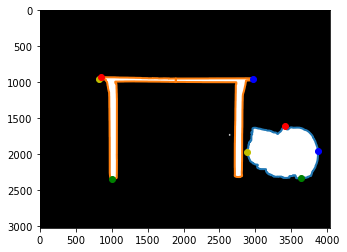

In [476]:
fig, ax = plt.subplots()
ax.imshow(mask_img, cmap=plt.cm.gray)
ax.plot(contour_1[:, 1], contour_1[:, 0], linewidth=2)

ax.plot(contour_2[:, 1], contour_2[:, 0], linewidth=2)

ax.plot(x_max[1], x_max[0], 'bo') # --> самая правая
ax.plot(x_min[1], x_min[0], 'yo') # --> самая левая
ax.plot(y_max[1], y_max[0], 'ro') # --> самая верхняя
ax.plot(y_min[1], y_min[0], 'go') # --> самая нижнаяя

ax.plot(x_max2[1], x_max2[0], 'bo') # --> самая правая
ax.plot(x_min2[1], x_min2[0], 'yo') # --> самая левая
ax.plot(y_max2[1], y_max2[0], 'ro') # --> самая верхняя
ax.plot(y_min2[1], y_min2[0], 'go') # --> самая нижнаяя


plt.show()

In [477]:
# Данный мето нужен, чтобы опрелелить точку, отвечающую за нижнюю точку столешницы стола

def find_dot(contour):
    for i in range(len(contour)):
        pair = contour[i]
        if(pair[1] == x_med[1]):
            print(pair)
            return pair

In [478]:
# Находим нижнюю точку столешницы стола

dot = find_dot(cont)

# Находим высоту пространства под столешницей (от самой нижней точки стола, до столешницы)

height_table = round(y_min2[0] - y_max2[0] - (dot[0] - x_med[0]))
print(height_table)

[ 997.8 1893. ]
1346


In [479]:
# Данный метод необходим для нахождения самой правой точки ЛЕВОЙ ножки стола

def find_left_leg(contour, dot):
    dot[0]+=50;
    print(dot)
    dots = []
    
    for i in range(len(contour)):
        pair = contour[i]
        if((pair[0] > dot[0] + 50) and pair[1] < dot[1]):
            dots.append(pair)
            
    min_d = x_min2    
    
    for i in range(len(dots)):
        pair = dots[i]
        if(pair[1] > min_d[1]):
            min_d = pair
            
    return min_d

In [480]:
# Данный метод необходим для нахождения самой левой точки ПРАВОЙ ножки стола

def find_right_leg(contour, dot):
    dots = []
    for i in range(len(contour)):
        pair = contour[i]
        if((pair[0] < dot[0] + 50) or pair[1] < dot[1]):
            continue
        else:
            dots.append(pair)
    min_d = x_max2        
    for i in range(len(dots)):
        pair = dots[i]
        if(pair[1] < min_d[1]):
            min_d = pair
            
    return min_d

In [481]:
# Правая точка для левой ножки

min_d = find_left_leg(cont, dot)
print(min_d)

# Левая точка для правой ножки
max_d = find_right_leg(cont, dot)
print(max_d)

[1047.8 1893. ]
[1285.  1074.2]
[2154.  2710.8]


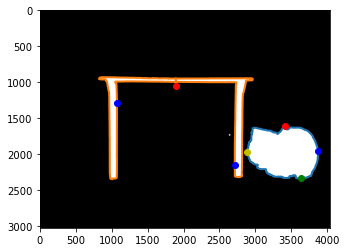

In [482]:
# Изобразим внутренние точки нашего стола

fig, ax = plt.subplots()
ax.imshow(mask_img, cmap=plt.cm.gray)
ax.plot(contour_1[:, 1], contour_1[:, 0], linewidth=2)

ax.plot(contour_2[:, 1], contour_2[:, 0], linewidth=2)

if(max_square > max_square2):
    ax.plot(x_max[1], x_max[0], 'bo') #max_y --> самая правая (max_x)
    ax.plot(x_min[1], x_min[0], 'yo') #min_y --> самая левая (min_x)
    ax.plot(y_max[1], y_max[0], 'ro') #min_x --> самая верхняя (max_y)
    ax.plot(y_min[1], y_min[0], 'go') #max_x --> самая нижнаяя (min_y)
else:
    ax.plot(x_max2[1], x_max2[0], 'bo') # --> самая правая
    ax.plot(x_min2[1], x_min2[0], 'yo') # --> самая левая
    ax.plot(y_max2[1], y_max2[0], 'ro') # --> самая верхняя
    ax.plot(y_min2[1], y_min2[0], 'go') # --> самая нижнаяя
    
ax.plot(dot[1], dot[0], 'ro')
ax.plot(min_d[1], min_d[0], 'bo')
ax.plot(max_d[1], max_d[0], 'bo')
plt.show()

In [483]:
# Посчитаем ширину пространства между ножками стола

width_table = round(max_d[1] - min_d[1])
print(width_table)
print(width_1)

1637
985.3999999999996


In [484]:
# Последняя проверка для выдачи ответа пользователю

if((width_table < width_1) or (height_table < height_1)):
    print("Too large or too height")
else:
    print("Ok.")

Ok.
